<a href="https://colab.research.google.com/github/zelatyna/Severstal/blob/master/Severstal_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Severstal : Steel Defect Detection
https://www.kaggle.com/c/severstal-steel-defect-detection/data

Learning U Nets with Tensorflow using Severstal Dataset from Keggle competition

Import packages

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import os, sys
import csv
from matplotlib import pyplot as plt
import PIL
import keras
from keras import backend as K
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint
from keras.losses import binary_crossentropy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
#Disable warnings
import warnings
warnings.filterwarnings('ignore')

## Download data
Download the dataset using Kaggle API directly to Google Drive via Google Colab

https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [8]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zelatyna","key":"b7f0e9b464499b89f76cff0d5f660b22"}'}

In [9]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [10]:
!kaggle competitions download -c severstal-steel-defect-detection -p /content/gdrive/My\ Drive/kaggle/severstal

  0% 0.00/6.91M [00:00<?, ?B/s]
100% 6.91M/6.91M [00:00<00:00, 63.4MB/s]
  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 143MB/s]
 99% 1.15G/1.16G [00:13<00:00, 84.4MB/s]
100% 1.16G/1.16G [00:13<00:00, 89.3MB/s]
 88% 114M/129M [00:04<00:00, 16.6MB/s]
100% 129M/129M [00:04<00:00, 32.8MB/s]


In [11]:
import os
os.chdir('gdrive/My Drive/kaggle/severstal')  #change dir
!mkdir train_images 
!mkdir test_images 
!unzip -q train_images.zip -d train_images/  
!unzip -q test_images.zip -d test_images/ 
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


### Data loading

In [0]:
test_path = '/content/gdrive/My Drive/kaggle/severstal/test_images'
train_path = '/content/gdrive/My Drive/kaggle/severstal/train_images'

In [0]:
def get_filenames(mypath): 
    return [mypath + '/' + f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

In [0]:
test_filenames = get_filenames(test_path)
train_filenames = get_filenames(train_path) 

In [15]:
print("number of test images:", len(test_filenames))

number of test images: 1801


In [16]:
train_size = len(train_filenames)
print("number of training images:", train_size)

number of training images: 12568


Get training labels / annotations

In [0]:
defects_df = pd.read_csv('train.csv')
defects_df['ImageId'] = defects_df['ImageId_ClassId'].apply(lambda x : x.split('_')[0])
defects_df['ClassId'] = defects_df['ImageId_ClassId'].apply(lambda x : x.split('_')[1])
defects_df['hasMask'] = ~ defects_df['EncodedPixels'].isna()

In [0]:
defects_df.set_index('ImageId_ClassId', inplace=True)

In [19]:
defects_df.head(5)

,EncodedPixels,ImageId,ClassId,hasMask
ImageId_ClassId,,,,
0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [20]:
defects_df.shape

(50272, 4)

## Example image and encoded mask

In [0]:
image_id = '0007a71bf.jpg'

In [0]:
sample_img = defects_df[defects_df['ImageId'] == image_id]

In [0]:
img_path = sample_img['ImageId'].unique()[0]

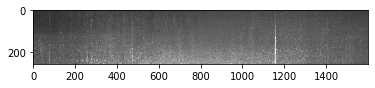

In [24]:
img = cv2.imread(train_path + '/' + img_path)
plt.imshow(img)

In [25]:
img[0]

array([[47, 47, 47],
       [49, 49, 49],
       [49, 49, 49],
       ...,
       [65, 65, 65],
       [67, 67, 67],
       [63, 63, 63]], dtype=uint8)

All masks are decoded in RLE, so we need to convert them back to masks

https://www.kaggle.com/titericz/building-and-visualizing-masks

Run-length encoding (RLE) is a very simple form of lossless data compression in which runs of data (sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run. 

In [0]:
'''
This function is an rle to mask converter.
You supply the rle string for one mask, along with it's height and width
from the solutions for stage1 and it will return the mask.
'''
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [0]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

Pictures are of size 256x1600 with 3 channel colors

In [28]:
img.shape

(256, 1600, 3)

In [0]:
sample_img.reset_index(inplace=True)

In [0]:
sample_rles = sample_img['EncodedPixels'].values

In [0]:
rleToMask = build_masks(sample_rles, (img.shape[0], img.shape[1]))

masks are stored as one channel

In [32]:
rleToMask.shape

(256, 1600, 4)

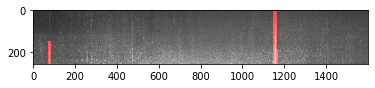

In [34]:
img[rleToMask[:, :, 2]==1,0] = 255
plt.imshow(img)

## Number of defects per class

Check the distribution of defects

In [35]:
defects_df[['ClassId', 'EncodedPixels']][defects_df['EncodedPixels'].notnull()].groupby(['ClassId']).count()

,EncodedPixels
ClassId,
1,897
2,247
3,5150
4,801


Most common deffect class is 3, then 1, followed by 4 and 2

Are there images with multiple defects? YES

In [0]:
image_by_defects = defects_df[['ImageId', 'EncodedPixels']][defects_df['EncodedPixels'].notnull()].groupby(['ImageId']).count().sort_values('EncodedPixels', ascending=False)

In [0]:
image_by_defects.reset_index(inplace=True)

In [0]:
image_by_defects.rename(columns = {'EncodedPixels' : 'hasMask'}, inplace=True)

In [39]:
image_by_defects.head()

,ImageId,hasMask
0,ef24da2ba.jpg,3
1,db4867ee8.jpg,3
2,84865746c.jpg,2
3,5665ada1b.jpg,2
4,eb44ad79d.jpg,2


## Example of an image with 3 defect classes

In [40]:
image = 'ef24da2ba.jpg' 
df_ = defects_df[defects_df['ImageId'] == image]
df_.head()

,EncodedPixels,ImageId,ClassId,hasMask
ImageId_ClassId,,,,
ef24da2ba.jpg_1,366699 32 366955 32 367210 33 367466 33 367722...,ef24da2ba.jpg,1,True
ef24da2ba.jpg_2,366338 17 366594 50 366850 82 367106 99 367362...,ef24da2ba.jpg,2,True
ef24da2ba.jpg_3,178369 64 178498 191 178690 255 178946 255 179...,ef24da2ba.jpg,3,True
ef24da2ba.jpg_4,NaN,ef24da2ba.jpg,4,False


In [0]:
# 1 - red, 
# 2 - yellow,
# 3 - green , 
# 4 - blue
colors = {0: [0, 0, 0], 1 : [255, 0, 0], 2: [255, 255, 0], 3: [0, 255, 0], 4: [0, 0, 255]}

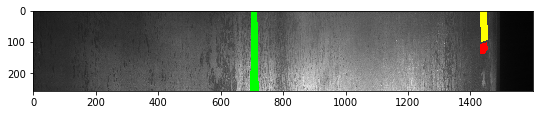

In [44]:
rows=3
columns=2
fig=plt.figure(figsize=(20, 5))
img = cv2.imread(train_path + '/' + image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rles = df_['EncodedPixels'].values
rleToMask = build_masks(rles, (img.shape[0], img.shape[1]))
fig.add_subplot(rows, columns, 1)
for c_id in range(1, 4+1):
    img[rleToMask[:, :, (c_id-1)]==1] = colors[c_id]
    plt.imshow(img) 
plt.show()

Display some more examples

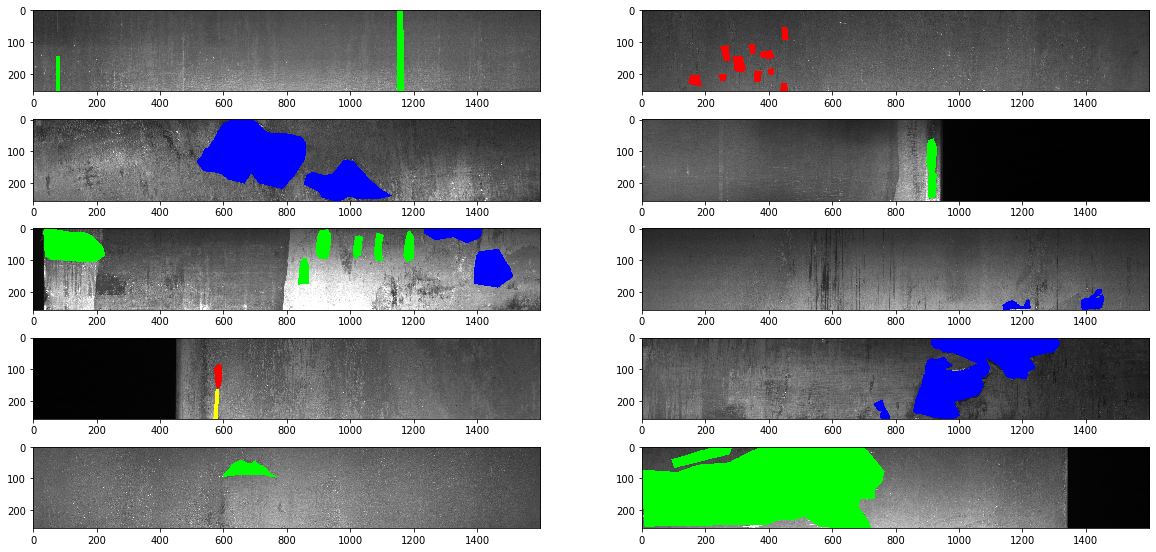

In [45]:
fig=plt.figure(figsize=(20,100))
columns = 2
rows = 50
train = defects_df[defects_df['EncodedPixels'].notnull()]['ImageId'].reset_index()
train = train['ImageId'].unique()
for i in range(1, 10+1):
    fig.add_subplot(rows, columns, i)
    fn = train[i]
    img = cv2.imread( 'train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    df_ = defects_df[defects_df['ImageId'] == fn].reset_index()
    rles = df_['EncodedPixels'].values
    rleToMask = build_masks(rles, (img.shape[0], img.shape[1]))
    for c_id in range(1, 4+1):
        img[rleToMask[:, :, (c_id-1)]==1] = colors[c_id]
    plt.imshow(img) 
plt.show()

In [47]:
## Unique images with defects
print('Unique images with defects')
no_defects = defects_df[defects_df['EncodedPixels'].notnull()]
len(no_defects['ImageId'].unique())

Unique images with defects


6666

In [48]:
len(defects_df['ImageId'].unique())

12568

There are images without defects and those should be excluded from the training dataset

### Data Generator
Following code has been copied from https://www.kaggle.com/zelatyna/severstal-simple-2-step-pipeline/edit

Another must read: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        #print(X.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
           
            img = self.__load_grayscale(img_path)
            
            # Store samples
            try:
                X[i,] = img
            except ValueError as e:
                print("ERR:")
                print(img_path)
                print(img.shape)

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

### Data split

In [0]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    image_by_defects.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=image_by_defects,
    target_df=defects_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=image_by_defects,
    target_df=defects_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

## Loss functions

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

## Model architecture
The following model is directly taken from this awesome kernel: https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data

In [0]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

## Training

In [53]:
model = build_model((256, 1600, 1))
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]            

## Run the model

In [54]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=7
)




Epoch 1/7





354/354 [==============================] - 151s 428ms/step - loss: 1.0369 - dice_coef: 0.0752 - val_loss: 0.9926 - val_dice_coef: 0.0928
Epoch 2/7
354/354 [==============================] - 141s 398ms/step - loss: 0.7284 - dice_coef: 0.3526 - val_loss: 0.6308 - val_dice_coef: 0.4398
Epoch 3/7
354/354 [==============================] - 138s 391ms/step - loss: 0.6079 - dice_coef: 0.4612 - val_loss: 0.5896 - val_dice_coef: 0.4803
Epoch 4/7
354/354 [==============================] - 140s 395ms/step - loss: 0.5839 - dice_coef: 0.4824 - val_loss: 0.5403 - val_dice_coef: 0.5146
Epoch 5/7
354/354 [==============================] - 141s 399ms/step - loss: 0.5613 - dice_coef: 0.5026 - val_loss: 0.5393 - val_dice_coef: 0.5257
Epoch 6/7
354/354 [==============================] - 140s 395ms/step - loss: 0.5382 - dice_coef: 0.5227 - val_loss: 0.5153 - val_dice_coef: 0.5412
Epoch 7/7
354/354 [==============================] - 141s 398ms/step - loss: 0.5348 - dice_coef: 0.5264 - val_

##Results evaluation


In [0]:
sub_df = pd.read_csv('sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

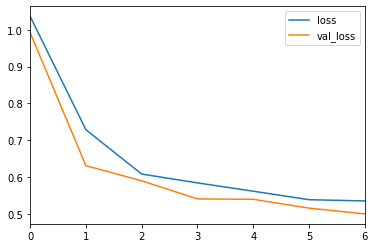

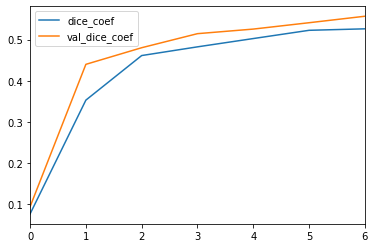

In [60]:
import json
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [80]:
#TQDM - A Fast, Extensible Progress Bar for Python and CLI
from tqdm import tqdm
model.load_weights('model.h5')
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        base_path=test_path,
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

test_df = pd.concat(test_df)

500/500 [==============================] - 5s 10ms/step


500it [00:11, 44.04it/s]

  1/500 [..............................] - ETA: 9s

500/500 [==============================] - 5s 10ms/step


500it [00:11, 43.67it/s]

  1/500 [..............................] - ETA: 8s

500/500 [==============================] - 5s 10ms/step


500it [00:11, 43.34it/s]

  1/301 [..............................] - ETA: 4s

301/301 [==============================] - 3s 10ms/step


301it [00:07, 42.46it/s]


### Sample test masks


['004f40c73.jpg' '006f39c41.jpg' '00b7fb703.jpg' ... 'ffbf79783.jpg'
 'ffc9a6187.jpg' 'ffdb60677.jpg']


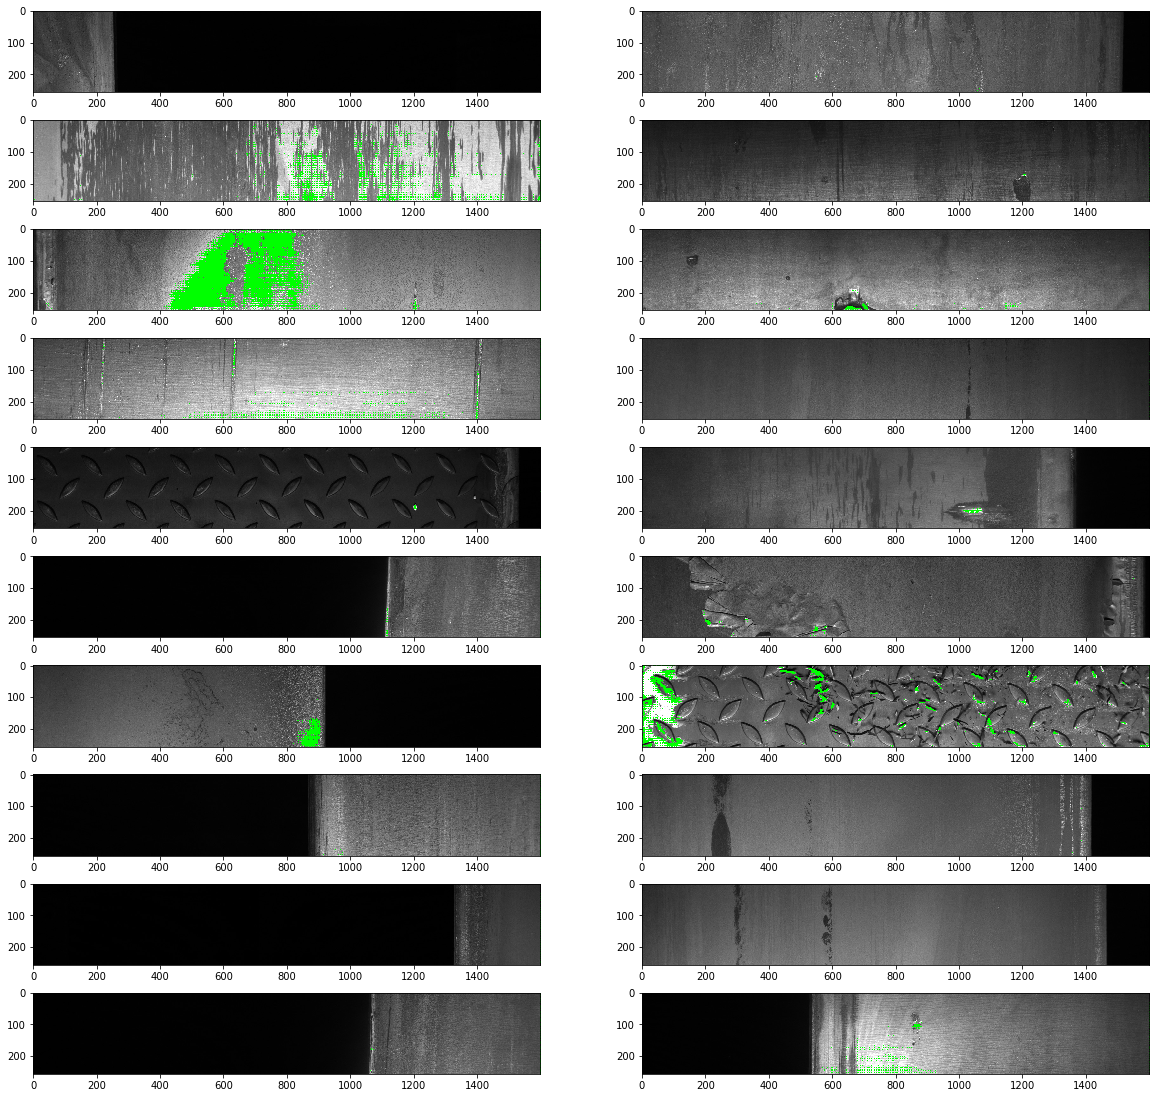

In [82]:
fig=plt.figure(figsize=(20,100))
columns = 2
rows = 50
image_ids  = test_df['ImageId'].unique()
for i in range(0, 20):
    train = test_df[test_df['ImageId']==image_ids[i]]
    fig.add_subplot(rows, columns, i+1)
    fn = train['ImageId'].unique()[0]
    img = cv2.imread( 'test_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rles = train['EncodedPixels'].values
    rleToMask = build_masks(rles, (img.shape[0], img.shape[1]))
    for c_id in range(1, 4+1):
        img[rleToMask[:, :, (c_id-1)]==1] = colors[c_id]
    plt.imshow(img) 
plt.show()

In [0]:
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('submission.csv', index=False)

In [0]:
files.download('submission.csv')